In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
2,605 cases (7 day average) as of Sat 29 May, +124.3 since Fri 28 May
86 hospitalised (7 day average) as of Mon 31 May, +0.0 since Sun 30 May
5 died (7 day average) as of Sat 29 May, +0.3 since Fri 28 May


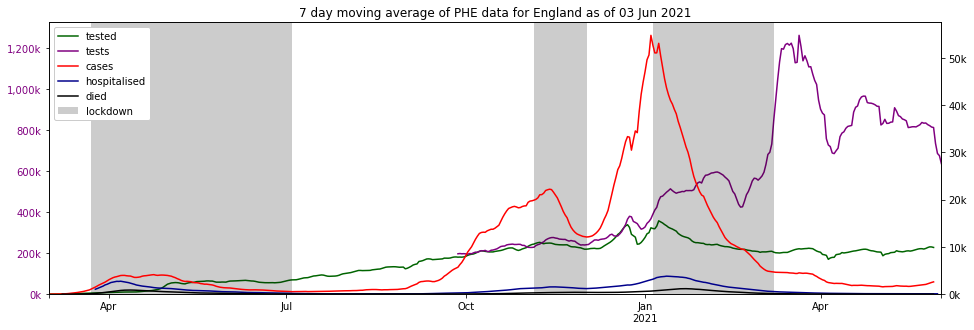

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

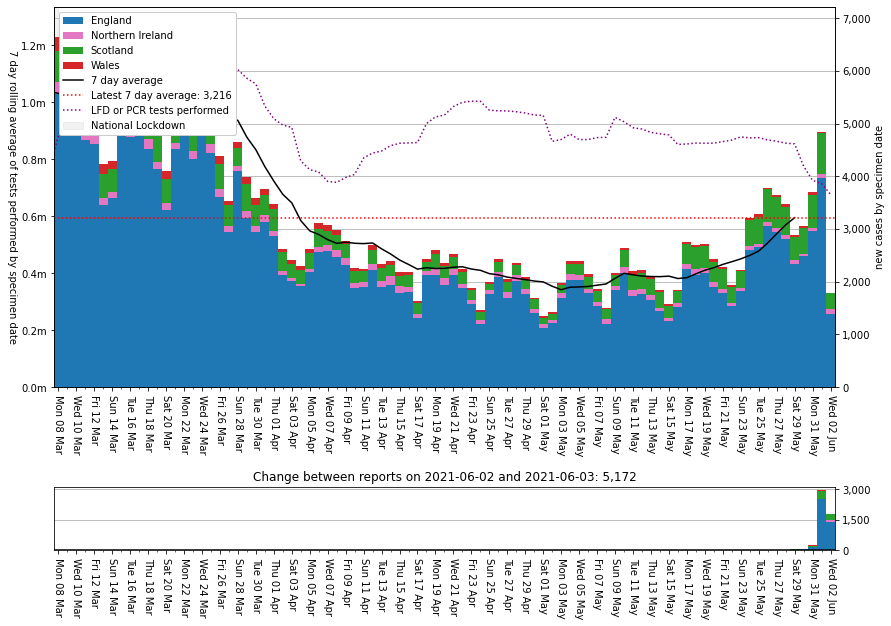

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

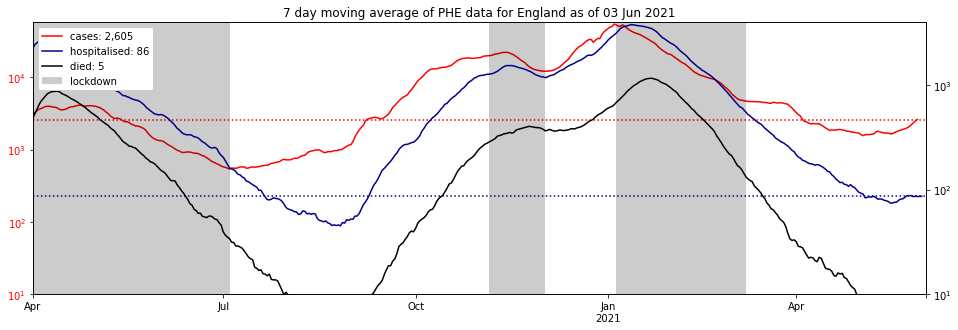

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

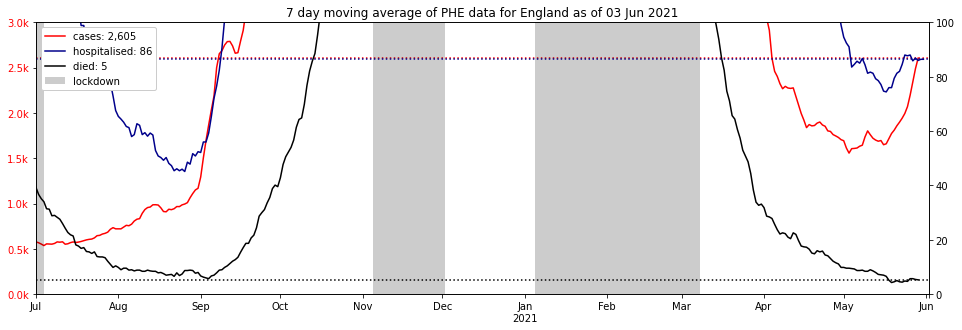

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,02 Jun 21,"+22,442,383","+33,217,813","+22,442,383","+288,963","+132,668","+288,963"
Northern Ireland,02 Jun 21,"+684,398","+1,073,775","+684,398","+8,823","+12,225","+8,823"
Scotland,02 Jun 21,"+2,137,618","+3,305,812","+2,137,618","+31,441","+19,551","+31,441"
Wales,02 Jun 21,"+1,157,904","+2,161,028","+1,157,904","+19,792","+8,319","+19,792"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,22442383.0,33217813.0,10775430.0,56286961,39.871371,19.143741,40.984888
1,Northern Ireland,N92000002,684398.0,1073775.0,389377.0,1893667,36.141412,20.562063,43.296525
2,Scotland,S92000003,2137618.0,3305812.0,1168194.0,5463300,39.126865,21.382571,39.490564
3,Wales,W92000004,1157904.0,2161028.0,1003124.0,3152879,36.725291,31.816127,31.458581


'partial: 39,758,428 (59.5%), full: 26,422,303'

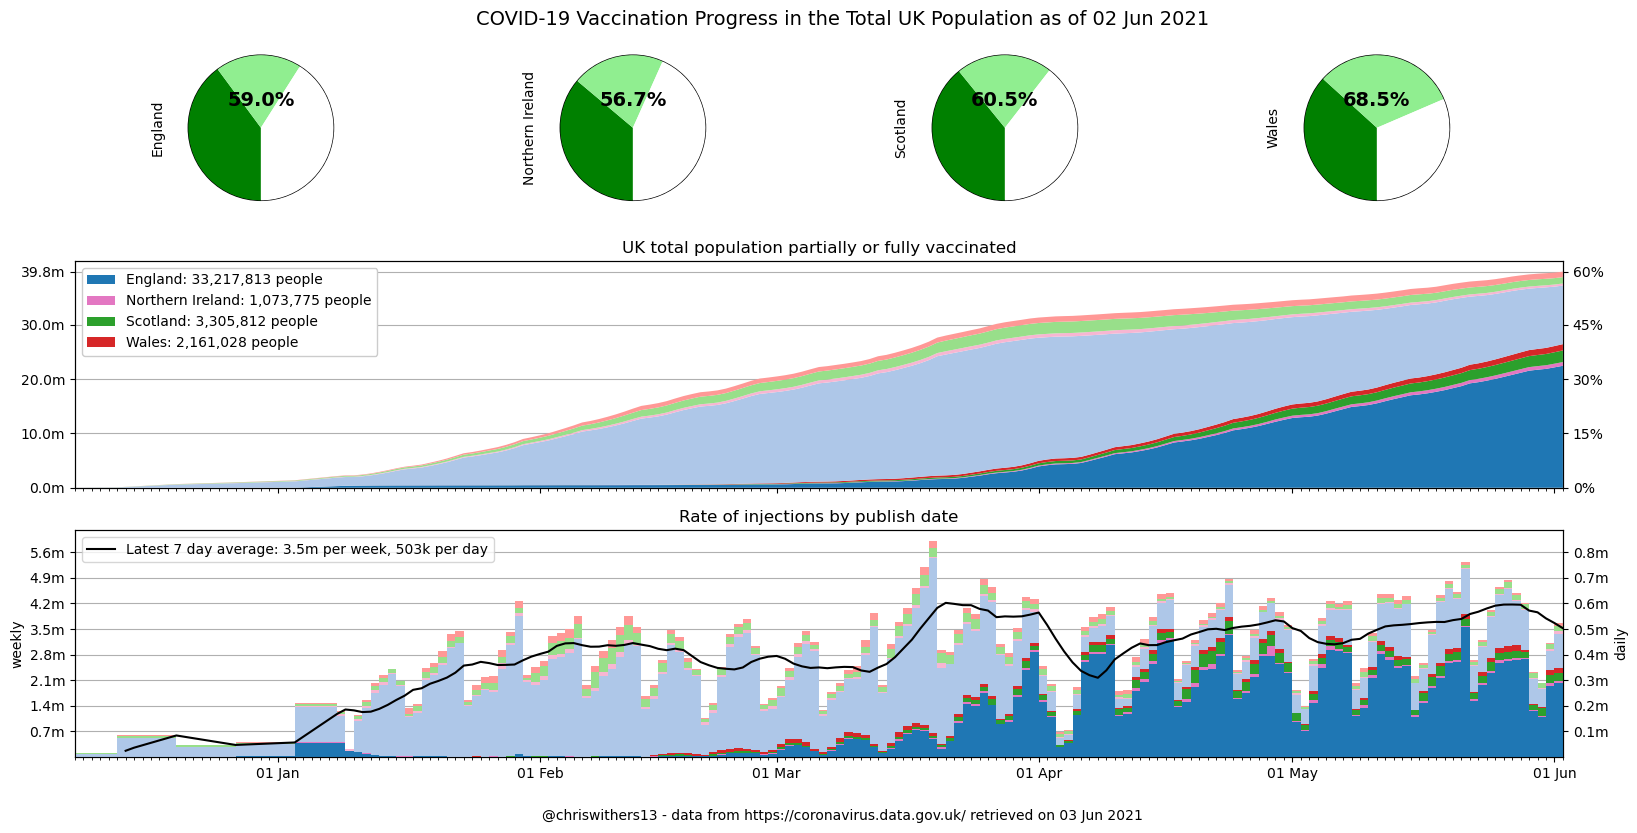

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

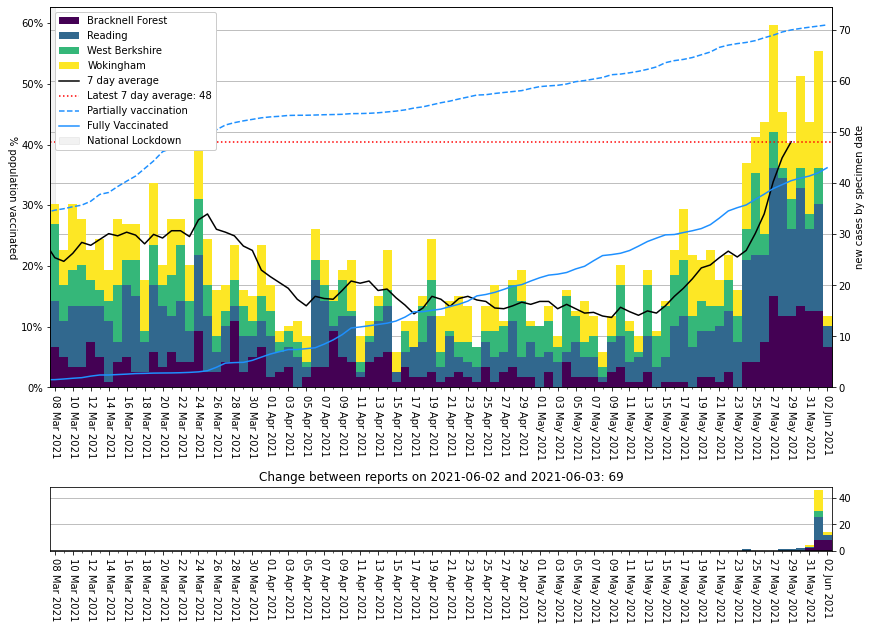

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1],  lines=population_vaccinated)

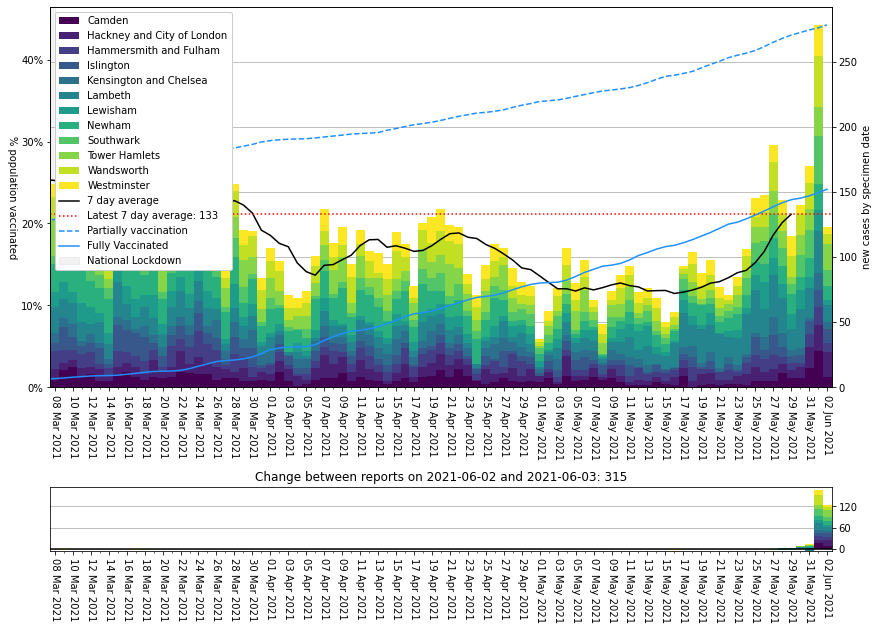

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,424.193031,635.0,2021-06-02
E08000001,Bolton,274.387063,789.0,2021-06-02
E07000125,Rossendale,251.811645,180.0,2021-06-02
E07000120,Hyndburn,215.934751,175.0,2021-06-02
E07000117,Burnley,166.441745,148.0,2021-06-02
E08000003,Manchester,155.193558,858.0,2021-06-02
E07000124,Ribble Valley,149.454737,91.0,2021-06-02
S12000011,East Renfrewshire,146.550822,140.0,2021-06-02
E08000006,Salford,145.266851,376.0,2021-06-02


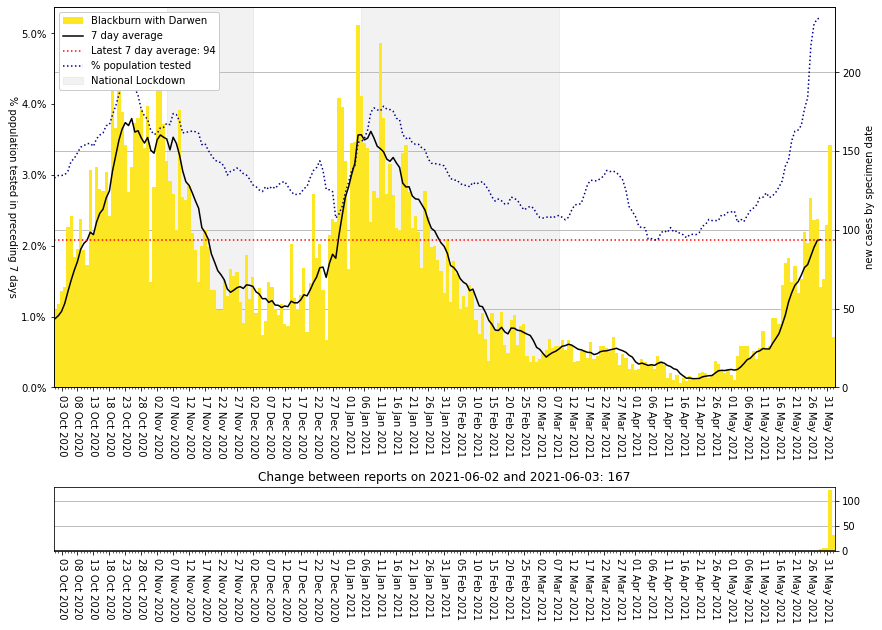

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,155.193558,858.0,2021-06-02
E08000001,Bolton,274.387063,789.0,2021-06-02
S12000049,Glasgow City,120.514278,763.0,2021-06-02
E06000008,Blackburn with Darwen,424.193031,635.0,2021-06-02
S12000036,City of Edinburgh,111.062427,583.0,2021-06-02
E08000025,Birmingham,41.425238,473.0,2021-06-02
E08000035,Leeds,54.593205,433.0,2021-06-02
E08000034,Kirklees,95.500777,420.0,2021-06-02
E08000006,Salford,145.266851,376.0,2021-06-02


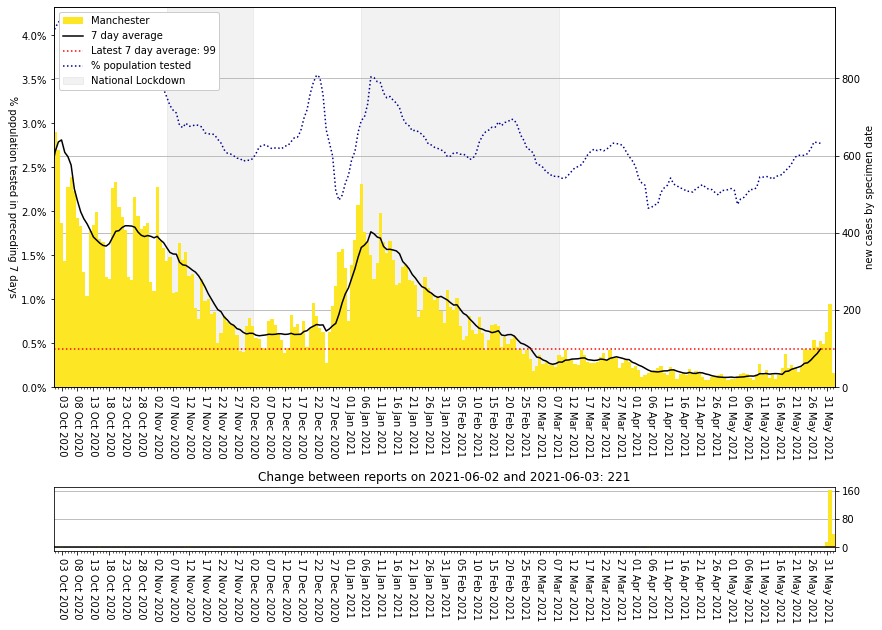

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

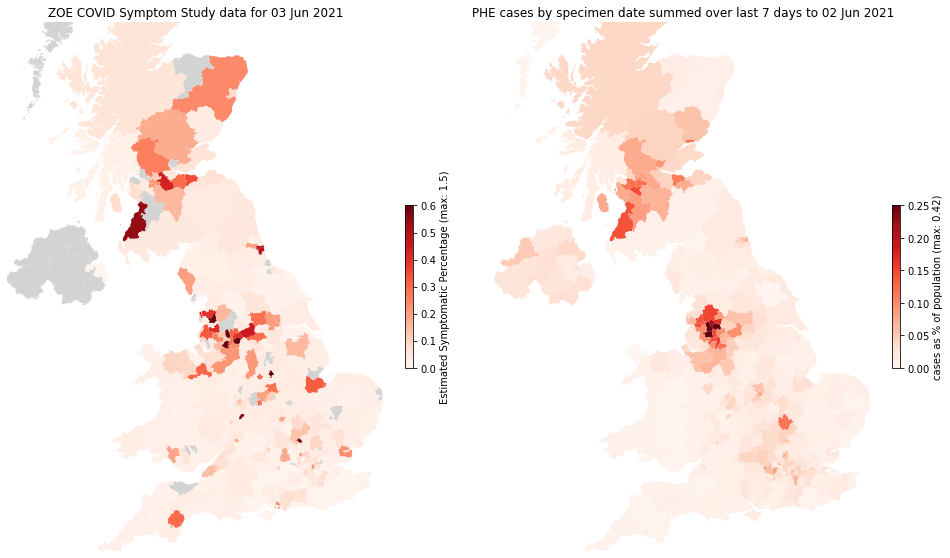

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...